In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
import os, pyrootutils
ROOT = pyrootutils.setup_root(os.getcwd(), dotenv=True, pythonpath=True, cwd=True)

In [3]:
from src import *
from ipywidgets import interact, widgets

In [4]:
config = Config()

# or 

config = load_config_locally('020_RX100_resized_128/0')


In [13]:
file = '12_iphone'
file = '001_Benatska_ESP32'
video = Video(file, config)

file "data/labels/**/001_Benatska_ESP32.txt" does not exist
file "data/csv/**/001_Benatska_ESP32.csv" does not exist


In [9]:
config_1 = deepcopy(config)
config_2 = deepcopy(config)

# config_2.transformation = Transformation.MFCC
# config_2.image_augmentations = True
# config_2.random_resized_crop = True

In [12]:
file_number = 0

video_1 = Video(file, config_1)
video_2 = Video(file, config_2)

transform_1 = create_transformation(config_1)
transform_2 = create_transformation(config_2)

signal_1 = video_1.signal.clone()
signal_2 = video_2.signal.clone()

def get_features(signal, transform, config, from_time, till_time):
    from_sample = from_time * config.sr
    till_sample = till_time * config.sr
    
    signal = signal[from_sample: till_sample]
    features = transform(signal).squeeze()
    
    return features

def f(from_time=0):
    till_time = from_time + 10

    features_1 = get_features(signal_1, transform_1, config_1, from_time, till_time)
    features_2 = get_features(signal_2, transform_2, config_2, from_time, till_time)

    vmin = min(features_1.min(), features_2.min())
    vmax = max(features_1.max(), features_2.max())
    
    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    ax1, ax2 = axes.flatten()

    print(features_1.shape, features_2.shape)
        
    im1 = ax1.pcolormesh(features_1, vmin=vmin, vmax=vmax)
    im2 = ax2.pcolormesh(features_2, vmin=vmin, vmax=vmax)
    
    # ax1.axis('off')
    # ax2.axis('off')
    # ax1.set_title('Spectrogram', fontsize=25)
    # ax2.set_title('Mel spectrogram', fontsize=25)
    
    plt.tight_layout()
    fig.colorbar(im2, ax=[ax1, ax2])
    # plt.savefig('plots/spec_vs_mel_spec.pdf')
    plt.show()

from_time_slider = widgets.IntSlider(min=0, max=60*20, step=1, value=260)
interact(f, from_time=from_time_slider);

file "data/labels/**/001_Benatska_ESP32.txt" does not exist
file "data/csv/**/001_Benatska_ESP32.csv" does not exist
file "data/labels/**/001_Benatska_ESP32.txt" does not exist
file "data/csv/**/001_Benatska_ESP32.csv" does not exist


interactive(children=(IntSlider(value=260, description='from_time', max=1200), Output()), _dom_classes=('widge…

### Compare global (across video) and local (across window) normalization

In [35]:
model, config = load_model_locally('one_location_gaussian_blur', 'rvce')
files = ['12_RX100']
datapool = DataPool(files, config.window_length, config.split_ratio, tqdm=tqdm)
transform = create_transformation(config)
signal = datapool[files[file_number]].signal.clone()

Video loading:   0%|          | 0/1 [00:00<?, ?it/s]

In [92]:
features_long = transform(signal).squeeze()

def find_windows(i):
    features_from = int(i * config.n_features_in_nn_hop)
    features_till = int(features_from + config.n_features_in_window)

    features_long_window = features_long[:, features_from:features_till]

    from_sample = int(i * config.n_samples_in_nn_hop)
    till_sample = int(from_sample + config.n_samples_in_window)

    signal_short = signal[from_sample: till_sample]

    features_short_window = transform(signal_short).squeeze()

    return features_long_window, features_short_window

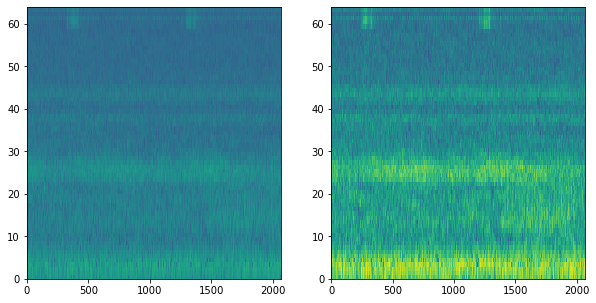

In [84]:
# features_long_window, features_short_window = find_windows(22)
features_long_window, features_short_window = find_windows(27)

fig, axes = plt.subplots(1, 2, figsize=(10,5))

vmin = min(features_long_window.min(), features_short_window.min())
vmax = max(features_long_window.max(), features_short_window.max())

axes[0].pcolormesh(features_long_window, vmin=vmin, vmax=vmax)
axes[1].pcolormesh(features_short_window, vmin=vmin, vmax=vmax)

In [96]:
vmin = features_long.min()
vmax = features_long.max()

def g(i=0):
    features_long_window, features_short_window = find_windows(i)

    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    axes[0].pcolormesh(features_long_window, vmin=vmin, vmax=vmax)
    axes[1].pcolormesh(features_short_window, vmin=vmin, vmax=vmax)
    plt.show()

# i = widgets.IntSlider(min=0, max=100, step=1, value=0)
i = widgets.FloatSlider(min=0, max=100, step=.2, value=0)
interact(g, i=i);

interactive(children=(FloatSlider(value=0.0, description='i', step=0.2), Output()), _dom_classes=('widget-inte…

In [20]:
config_1 = deepcopy(config)
config_2 = deepcopy(config)

config_1.log_transformation = False
config_1.normalization = Normalization.NONE
config_1.resize_size = [512, 512]

config_2.normalization = Normalization.NONE
config_2.resize_size = [512, 512]

file_number = 0

video_1 = Video(file, config_1)
video_2 = Video(file, config_2)

transform_1 = create_transformation(config_1)
transform_2 = create_transformation(config_2)

signal_1 = video_1.signal.clone()
signal_2 = video_2.signal.clone()

def get_features(signal, transform, config, from_time, till_time):
    from_sample = from_time * config.sr
    till_sample = till_time * config.sr
    
    signal = signal[from_sample: till_sample]
    features = transform(signal).squeeze()
    
    return features

def f(from_time=0):
    till_time = from_time + 10

    features_1 = get_features(signal_1, transform_1, config_1, from_time, till_time)
    features_2 = get_features(signal_2, transform_2, config_2, from_time, till_time)

    fig, axes = plt.subplots(ncols=3, figsize=(16,5))
    ax1, ax2, ax3 = axes.flatten()

    each = 16
    from_sample = from_time * config.sr
    till_sample = till_time * config.sr
    signal = signal_1[from_sample: till_sample]
        
    im = ax1.plot(signal[::each])
    im = ax2.pcolormesh(features_1)
    im = ax3.pcolormesh(features_2)
    
    # for ax in axes:
    #     ax.axis('off')
    
    plt.tight_layout()
    # fig.colorbar(im, ax=axes)
    plt.savefig('plots/signal_spec_logspec.png', dpi=300)
    plt.show()

from_time_slider = widgets.IntSlider(min=0, max=60*20, step=1, value=260)
interact(f, from_time=from_time_slider);

interactive(children=(IntSlider(value=260, description='from_time', max=1200), Output()), _dom_classes=('widge…